# Desafio 4Inteligence Data Science

### A partir da série de inadimplência , disponível em : https://dadosabertos.bcb.gov.br/dataset/21082 <br /> inadimplencia da carteira de credito total
1.
Projete a taxa de
inadimplência dos próximos 12 meses;
2.
Como
você defenderia essa projeção ? Quais
são provavelmente , os principais drivers desses valores

# 1 Projete a taxa de inadimplência dos próximos 12 meses;

### Para este case utilizei 3 modelos diferentes Arima, Linear Regression e LSTM

### Modelo 1 Linear Regression:


In [36]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Convertendo a string de dados para um DataFrame
data = "./csv_serie-sgs-21082 .csv"

df = pd.read_csv(data, sep=";", decimal=",", parse_dates=["data"])
df['valor'] = df['valor'].astype(float)

df.head()
df.dtypes

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

values = df["valor"].values.reshape(-1, 1)
data_supervised = series_to_supervised(values, 12, 1)

##Gerando o modelo:
X, y = data_supervised.values[:, :-1], data_supervised.values[:, -1]

# Split em treino e teste (usando os últimos 12 meses para teste)
X_train, X_test = X[:-12], X[-12:]
y_train, y_test = y[:-12], y[-12:]

model = LinearRegression()
model.fit(X_train, y_train)

# Fazendo a previsão
predictions = model.predict(X_test)

#Acuracia:
mse = mean_squared_error(y_test, predictions)
print(f'MSE: {mse}')

print(predictions)


MSE: 0.003480279068357753
[2.82046248 2.85926549 2.89690128 3.02818307 2.98320157 3.09625739
 3.2266878  3.32199296 3.36151228 3.51336435 3.56258937 3.64160146]


## Modelo 2 LSTM model

In [48]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Lendo o dataset
data = "./csv_serie-sgs-21082 .csv"

df = pd.read_csv(data, sep=";", decimal=",", parse_dates=["data"])
df['valor'] = df['valor'].astype(float)

# Normalizando os dados
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df["valor"].values.reshape(-1, 1))

# Transformando a série temporal em um problema de aprendizado supervisionado
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 12
X, y = create_dataset(scaled_data, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Modelo LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X, y, epochs=50, batch_size=1, verbose=2)

# Projeção para os próximos 12 meses
inputs = scaled_data[-look_back:]
inputs = inputs.reshape(-1, look_back, 1)
future_preds = []

for i in range(12):
    pred = model.predict(inputs)
    future_preds.append(pred[0][0])

    # Atualize os inputs
    inputs = np.roll(inputs, shift=-1)
    inputs[0][-1][0] = pred

future_preds = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

print(future_preds)

Epoch 1/50
136/136 - 2s - loss: 0.0399 - 2s/epoch - 12ms/step
Epoch 2/50
136/136 - 0s - loss: 0.0143 - 406ms/epoch - 3ms/step
Epoch 3/50
136/136 - 0s - loss: 0.0095 - 399ms/epoch - 3ms/step
Epoch 4/50
136/136 - 0s - loss: 0.0073 - 406ms/epoch - 3ms/step
Epoch 5/50
136/136 - 0s - loss: 0.0060 - 403ms/epoch - 3ms/step
Epoch 6/50
136/136 - 0s - loss: 0.0054 - 405ms/epoch - 3ms/step
Epoch 7/50
136/136 - 0s - loss: 0.0048 - 408ms/epoch - 3ms/step
Epoch 8/50
136/136 - 0s - loss: 0.0049 - 397ms/epoch - 3ms/step
Epoch 9/50
136/136 - 0s - loss: 0.0048 - 406ms/epoch - 3ms/step
Epoch 10/50
136/136 - 0s - loss: 0.0046 - 403ms/epoch - 3ms/step
Epoch 11/50
136/136 - 0s - loss: 0.0047 - 403ms/epoch - 3ms/step
Epoch 12/50
136/136 - 0s - loss: 0.0040 - 410ms/epoch - 3ms/step
Epoch 13/50
136/136 - 0s - loss: 0.0042 - 412ms/epoch - 3ms/step
Epoch 14/50
136/136 - 0s - loss: 0.0039 - 407ms/epoch - 3ms/step
Epoch 15/50
136/136 - 0s - loss: 0.0039 - 407ms/epoch - 3ms/step
Epoch 16/50
136/136 - 0s - loss: 0.0

# modelo 3 Arima

In [47]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from io import StringIO
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# Lendo o dataset
data = "./csv_serie-sgs-21082 .csv"

df = pd.read_csv(data, sep=";", decimal=",", parse_dates=["data"])
df.set_index("data", inplace=True)
df['valor'] = df['valor'].astype(float)

# Função para verificar a estacionariedade
def test_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    return result[1] <= 0.05

# Verificar se os dados são estacionários
is_stationary = test_stationarity(df['valor'])

# Diferenciar se os dados não são estacionários
if not is_stationary:
    df['valor_diff'] = df['valor'] - df['valor'].shift(1)
    df.dropna(inplace=True)

# Escolhendo os parâmetros p, d, q. Para simplificar, usaremos (1,1,1)
# Em prática real, você pode querer usar algo como a função auto_arima do pacote pmdarima para selecionar automaticamente os melhores parâmetros
model = ARIMA(df['valor'], order=(1,1,1))
model_fit = model.fit()

# Fazendo previsões
forecast = model_fit.forecast(steps=12)
print(forecast)

149    3.630146
150    3.656912
151    3.680678
152    3.701780
153    3.720516
154    3.737152
155    3.751923
156    3.765038
157    3.776683
158    3.787022
159    3.796202
160    3.804354
Name: predicted_mean, dtype: float64


# Como você defenderia essa projeção ? Quais são provavelmente , os principais drivers desses valores

### Metodologia: 
ARIMA: É um modelo clássico de séries temporais que captura padrões autoregressivos, diferenças e médias móveis em uma série. 
É amplamente usado em finanças e econometria devido à sua simplicidade e eficácia.

LSTM: Uma rede neural projetada especificamente para séries temporais e sequências. Tem a capacidade de lembrar padrões de 
longo prazo e pode capturar relações não lineares nos dados.

Regressão Linear: É um dos modelos mais básicos, mas pode ser eficaz se a série tiver uma tendência linear clara.

### Conclusão: 
Utilizei as três técnicas de modelagem - ARIMA, LSTM e Regressão Linear - para projetar tendências futuras com base em dados históricos, e a consistência nas previsões desses modelos aumenta nossa confiança, embora fatores externos não refletidos nos dados possam influenciar os resultados futuros, ou seja os principais drivers são as colunas valores, e claro o historico dos dados claro que em uma aplicação real os dados precisam ser de fato melhores e contento mais historicos para melhorar o modelo, porém ainda sim existe a possibilidade de anexar outros dados de forma a deixar melhor aderente a projeção.

.

.

# Classificação:

Nos mercados de crédito , um problema típico é saber se, dadas as informações de uma pessoa , ela pagará ou não sua dívida . A partir da base disponível em https://www.kaggle.com/datasets/uciml/default of credit card clients dataset?resource=download gere um modelo preditivo de classificação variável target: ‘ default.payment.next.month ’), 
separe 30% da base para teste e traga métricas para validar o modelo em questão.

In [56]:
# Criação do modelo:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [57]:
df = pd.read_csv('./UCI_Credit_Card.csv')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [58]:
X = df.drop(columns=['default.payment.next.month'])
y = df['default.payment.next.month']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [59]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [63]:
y_pred = clf.predict(X_test)

In [64]:
# Acurácia
print("Acurácia:", accuracy_score(y_test, y_pred))

# Relatório de classificação
print(classification_report(y_test, y_pred))

# Matriz de Confusão
print(confusion_matrix(y_test, y_pred))

Acurácia: 0.8133333333333334
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      7040
           1       0.62      0.36      0.45      1960

    accuracy                           0.81      9000
   macro avg       0.73      0.65      0.67      9000
weighted avg       0.79      0.81      0.79      9000

[[6619  421]
 [1259  701]]


### Para Validação do teste realizado podemos realizar o cross val score e utilizar o seaborn para ver os valores previstos e verdadeiros

Acurácia em cada iteração da validação cruzada: [0.82119048 0.82071429 0.81738095 0.81714286 0.81214286]
Acurácia média na validação cruzada: 0.8177142857142856
Desvio padrão da acurácia na validação cruzada: 0.0032422941962950676


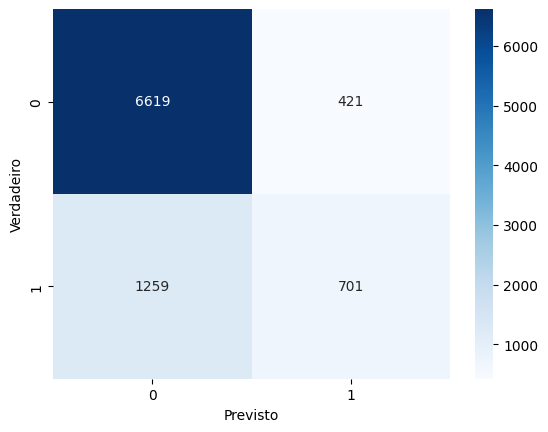

In [68]:
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt

scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')

print("Acurácia em cada iteração da validação cruzada:", scores)
print("Acurácia média na validação cruzada:", scores.mean())
print("Desvio padrão da acurácia na validação cruzada:", scores.std())

confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.show()

# Conclusão:
Em resumo, a validação fornece uma visão clara de como o modelo pode se comportar em dados não vistos anteriormente. 
Ao usar tanto a validação cruzada quanto a avaliação no conjunto de teste, você obtém uma imagem mais completa do 
desempenho do modelo, gerando assim uma visão mais ampla e continua dos dados de forma clara e objetiva.